- in our original agenda this week we try different covariance estimation method
- but I think we'd better go directly to regression model
- then we can save some time for further more complicate machine learning models


- this week we focus on the most simple linear regression without regularization

In [482]:
from helper import *
from stats import *
from imp import reload   
import helper
import stats
import  sklearn.preprocessing
reload(helper)
reload(stats)


<module 'stats' from 'C:\\Users\\dell\\stats.py'>

In [257]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM 

16

- number of cores, set this number according to your computer

- sample period

In [348]:
period = 4096
product_list = ["btc.usd.td", "eth.usd.td", "btc.usdt", "eth.usdt"]

- get all of the days

In [259]:
import dask
from dask import compute, delayed

In [260]:
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates.sort()
all_dates = np.array(all_dates)
n_days = len(all_dates)
n_days
## 1092

1092

In [362]:
SAVE_PATH = "e:/intern"
all_dates_x = os.listdir(DATA_PATH + product_list[0])
all_dates_y = os.listdir(DATA_PATH + product_list[1])
all_dates = np.array(list(set(all_dates_x) & set(all_dates_y)))
all_dates.sort()
train_sample = all_dates<"2019-08"
test_sample = all_dates>"2019-08"
date_str = [n[0:10] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])

In [435]:
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
signal_list = [signal+".4096" for signal in all_signal_list]

In [436]:
np.append(signal_list, ["ret.4096", "ret.4096.001", "ret.4096.002"])

array(['nr.4096', 'dbook.4096', 'range.pos.4096', 'price.osci.4096',
       'ma.dif.10.4096', 'kdj.k.4096', 'kdj.j.4096', 'nr.range.4096',
       'dbook.range.4096', 'range.pos.range.4096',
       'price.osci.range.4096', 'ma.dif.10.range.4096',
       'kdj.k.range.4096', 'kdj.j.range.4096', 'nr.std.4096',
       'dbook.std.4096', 'range.pos.std.4096', 'price.osci.std.4096',
       'ma.dif.10.std.4096', 'kdj.k.std.4096', 'kdj.j.std.4096',
       'nr.trend.index.4096', 'dbook.trend.index.4096',
       'range.pos.trend.index.4096', 'price.osci.trend.index.4096',
       'ma.dif.10.trend.index.4096', 'kdj.k.trend.index.4096',
       'kdj.j.trend.index.4096', 'ret.4096', 'ret.4096.001',
       'ret.4096.002'], dtype='<U27')

In [574]:
data = load(DATA_PATH+product_list[0]+"/"+all_dates[9])
data = data.reset_index(drop=True);

- let's begin with week 7 

- to build up a regression model, we need predictors and response variables
- the previous signals can be predictors
- now we need to create a response

- for example, we can use future log returns as response

- here fcum means the future sum of data
- for example

In [575]:
sample_y = fcum(data["ret"], period)

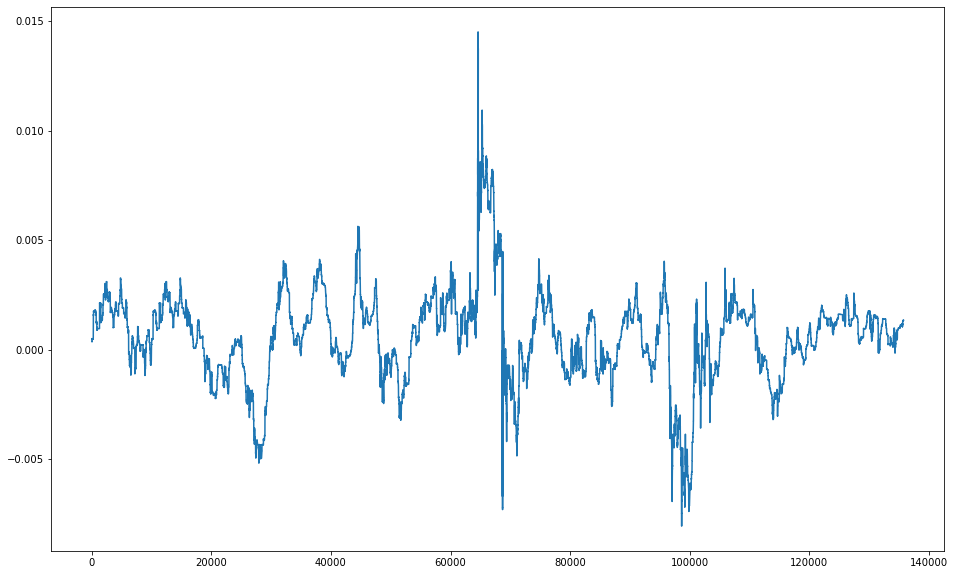

In [576]:
plt.figure(1, figsize=(16, 10))
plt.plot(sample_y[data["good"]].values);

In [577]:
kurtosis(sample_y[data["good"]], fisher=False)
## 6.020208102723735

6.020208102723735

- the response has quite high kurtosis, it means the response has fat tails


- we can check the result

In [578]:
np.sum(data["ret"][3000:(3000+period)])
## 0.002470774245956856

0.0026166160667511207

In [579]:
sample_y[2999]

0.0026166160667511207

- so fcum means future sume, and ys is the future price return

- now we create directory for this response signal

In [382]:
## calculate future return
class foctor_ret_period(factor_template):
    factor_name = "ret.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return fcum(data["ret"],period).values
    
y = foctor_ret_period()



In [383]:
for product in product_list:
    create_signal_path(y, product,SAVE_PATH);

e:/intern/tmp pkl/btc.usd.td/ret.1024
e:/intern/tmp pkl/btc.usd.td/ret.2048
e:/intern/tmp pkl/btc.usd.td/ret.4096
e:/intern/tmp pkl/eth.usd.td/ret.1024
e:/intern/tmp pkl/eth.usd.td/ret.2048
e:/intern/tmp pkl/eth.usd.td/ret.4096
e:/intern/tmp pkl/btc.usdt/ret.1024
e:/intern/tmp pkl/btc.usdt/ret.2048
e:/intern/tmp pkl/btc.usdt/ret.4096
e:/intern/tmp pkl/eth.usdt/ret.1024
e:/intern/tmp pkl/eth.usdt/ret.2048
e:/intern/tmp pkl/eth.usdt/ret.4096


In [388]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=y, product=product, HEAD_PATH=SAVE_PATH,n=14)
;
# Wall time: 5min 12s

Wall time: 5min 12s


''

- now let's see how it looks like

In [386]:
SAVE_PATH = "e:/intern"

In [390]:
%%time
for product in product_list[0:2]:
    parLapply(CORE_NUM, ["ret.4096"], par_get_all_signal, file_list=all_dates, product=product, period=4096, SAVE_PATH = SAVE_PATH);

# Wall time: 30.7 s

Wall time: 30.7 s


In [399]:
all_signal = load(SAVE_PATH+"/all signal/"+ product_list[0]+ ".ret."+str(period)+".pkl")
all_signal[np.isnan(all_signal)] = 0

- plot the signal

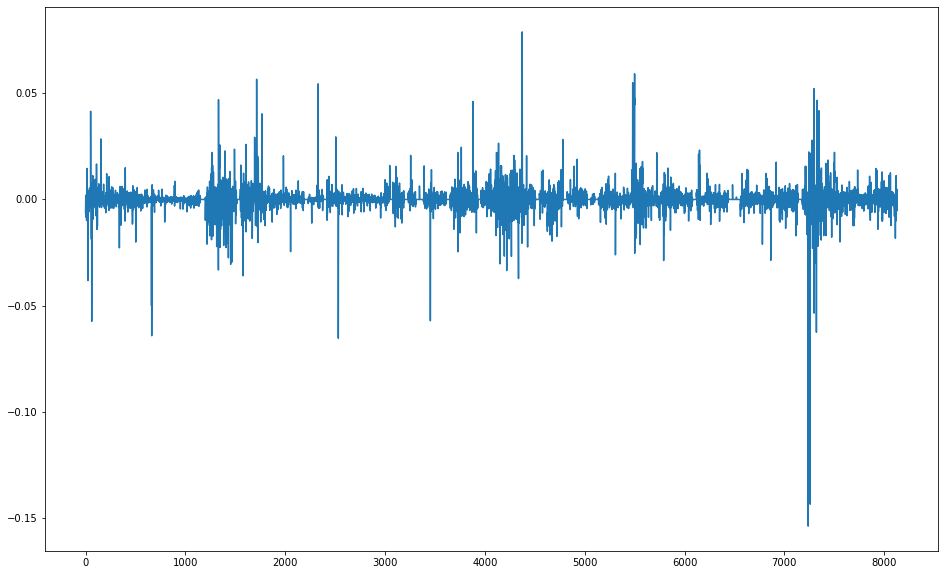

In [400]:
plt.figure(1, figsize=(16, 10))
plt.plot(all_signal);


- check the statistics of the signal

In [401]:
np.where(np.isnan(all_signal))

(array([], dtype=int64),)

In [402]:
print("kurtosis=", kurtosis(all_signal, fisher=False), " skew=", skew(all_signal))
## kurtosis= 125.69030334030893  skew= -4.042159028819147
## we can see it has very fat tails
## usually we don't adjust for response because we want to profit from the fat tails

kurtosis= 125.69030334030893  skew= -4.042159028819147


- let's try some vanish signal

kurtosis= 17.175934819150395  skew= -0.18472560796455703


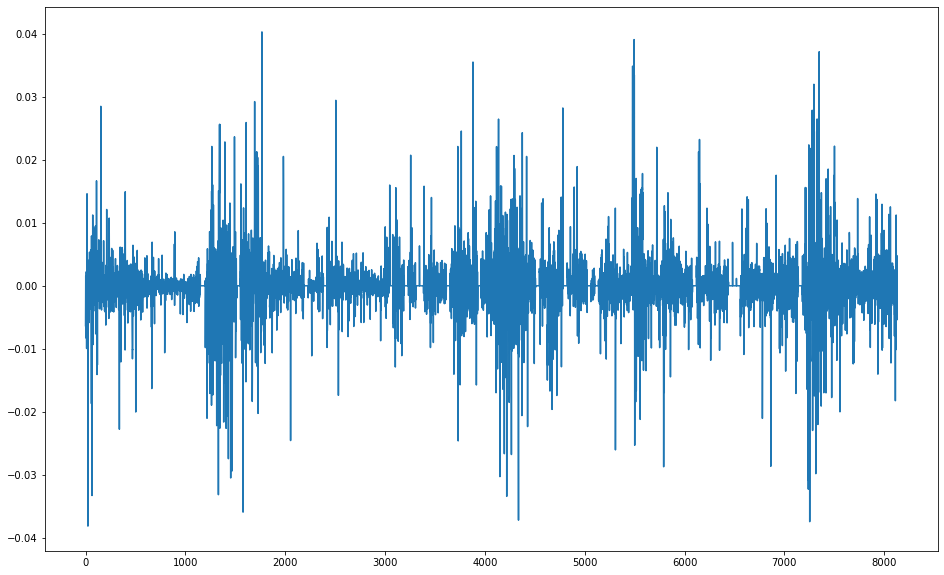

In [404]:
all_signal = load(SAVE_PATH+"/all signal/"+ product_list[0]+ ".ret."+str(period)+".pkl")
all_signal[np.isnan(all_signal)] = 0
vanish_signal = vanish_thre(all_signal, 0.041)
print("kurtosis=", kurtosis(vanish_signal, fisher=False), " skew=", skew(vanish_signal))
## kurtosis= 17.175934819150395  skew= -0.18472560796455703
plt.figure(1, figsize=(16, 10))
plt.plot(vanish_signal);

kurtosis= 8.988163812284247  skew= -0.15211034759982459


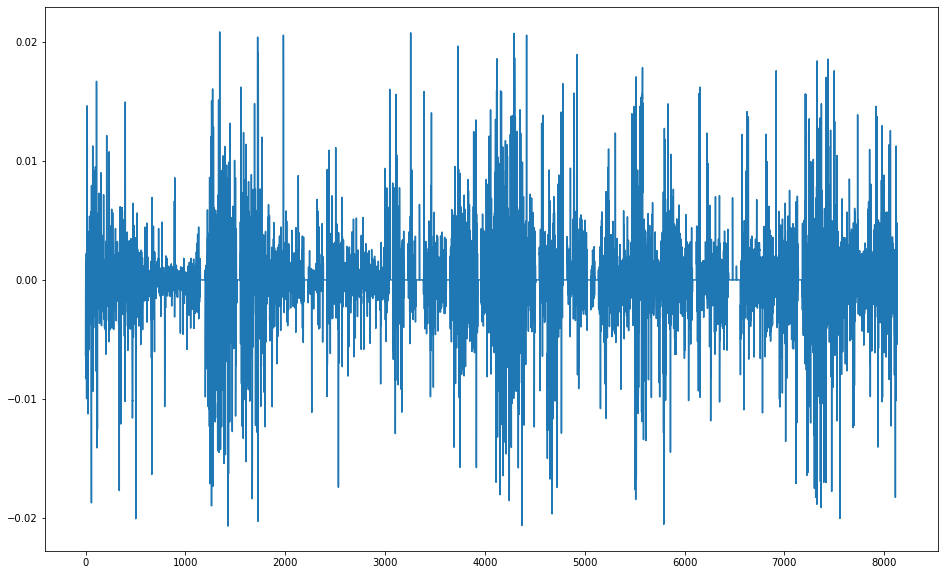

In [405]:
all_signal = load(SAVE_PATH+"/all signal/"+ product_list[0]+ ".ret."+str(period)+".pkl")
all_signal[np.isnan(all_signal)] = 0
vanish_signal = vanish_thre(all_signal, 0.021)
print("kurtosis=", kurtosis(vanish_signal, fisher=False), " skew=", skew(vanish_signal))
plt.figure(1, figsize=(16, 10))
plt.plot(vanish_signal);
## kurtosis= 8.988163812284247  skew= -0.15211034759982459


kurtosis= 5.48682803833185  skew= -0.1612669605531899


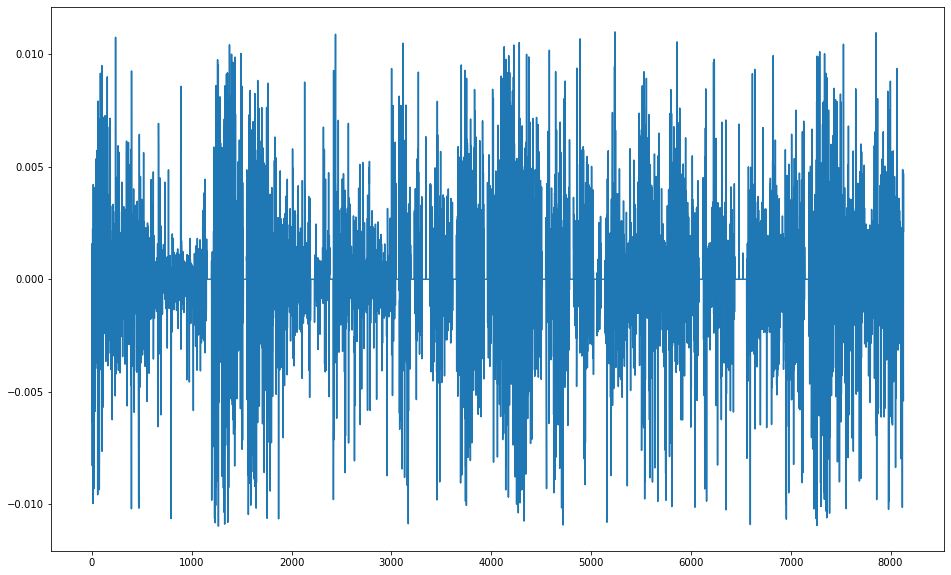

In [406]:
all_signal = load(SAVE_PATH+"/all signal/"+ product_list[0]+ ".ret."+str(period)+".pkl")
all_signal[np.isnan(all_signal)] = 0
vanish_signal = vanish_thre(all_signal, 0.011)
print("kurtosis=", kurtosis(vanish_signal, fisher=False), " skew=", skew(vanish_signal))
plt.figure(1, figsize=(16, 10))
plt.plot(vanish_signal);
## kurtosis= 5.48682803833185  skew= -0.1612669605531899

- it seems 0.01 fits our previous standard for predictive signals
- but now we works for response so there may be some differences


- let's create signals with vanish as well
- our function can support only one parameter so we create twice

In [407]:
class foctor_ret_period_004(factor_template):
    factor_name = "ret.period.004"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.041).values
    
y4 = foctor_ret_period_004()



In [408]:
class foctor_ret_period_002(factor_template):
    factor_name = "ret.period.002"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.021).values
    
y2 = foctor_ret_period_002()



In [409]:
for product in product_list:
    create_signal_path(y4, product, SAVE_PATH)

e:/intern/tmp pkl/btc.usd.td/ret.1024.004
e:/intern/tmp pkl/btc.usd.td/ret.2048.004
e:/intern/tmp pkl/btc.usd.td/ret.4096.004
e:/intern/tmp pkl/eth.usd.td/ret.1024.004
e:/intern/tmp pkl/eth.usd.td/ret.2048.004
e:/intern/tmp pkl/eth.usd.td/ret.4096.004
e:/intern/tmp pkl/btc.usdt/ret.1024.004
e:/intern/tmp pkl/btc.usdt/ret.2048.004
e:/intern/tmp pkl/btc.usdt/ret.4096.004
e:/intern/tmp pkl/eth.usdt/ret.1024.004
e:/intern/tmp pkl/eth.usdt/ret.2048.004
e:/intern/tmp pkl/eth.usdt/ret.4096.004


In [410]:
for product in product_list:
    create_signal_path(y2, product, SAVE_PATH)

e:/intern/tmp pkl/btc.usd.td/ret.1024.002
e:/intern/tmp pkl/btc.usd.td/ret.2048.002
e:/intern/tmp pkl/btc.usd.td/ret.4096.002
e:/intern/tmp pkl/eth.usd.td/ret.1024.002
e:/intern/tmp pkl/eth.usd.td/ret.2048.002
e:/intern/tmp pkl/eth.usd.td/ret.4096.002
e:/intern/tmp pkl/btc.usdt/ret.1024.002
e:/intern/tmp pkl/btc.usdt/ret.2048.002
e:/intern/tmp pkl/btc.usdt/ret.4096.002
e:/intern/tmp pkl/eth.usdt/ret.1024.002
e:/intern/tmp pkl/eth.usdt/ret.2048.002
e:/intern/tmp pkl/eth.usdt/ret.4096.002


In [411]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=y4, product=product, HEAD_PATH=SAVE_PATH, n=14)
;
## Wall time:  4min 45s

Wall time: 4min 45s


''

In [412]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=y2, product=product, HEAD_PATH=SAVE_PATH,n=14)
;
## Wall time: 5min 31s

Wall time: 4min 45s


''

In [413]:
class foctor_ret_period_001(factor_template):
    factor_name = "ret.period.001"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.011).values
    
y1 = foctor_ret_period_001()


In [414]:
for product in product_list:
    create_signal_path(y1, product, SAVE_PATH)

e:/intern/tmp pkl/btc.usd.td/ret.1024.001
e:/intern/tmp pkl/btc.usd.td/ret.2048.001
e:/intern/tmp pkl/btc.usd.td/ret.4096.001
e:/intern/tmp pkl/eth.usd.td/ret.1024.001
e:/intern/tmp pkl/eth.usd.td/ret.2048.001
e:/intern/tmp pkl/eth.usd.td/ret.4096.001
e:/intern/tmp pkl/btc.usdt/ret.1024.001
e:/intern/tmp pkl/btc.usdt/ret.2048.001
e:/intern/tmp pkl/btc.usdt/ret.4096.001
e:/intern/tmp pkl/eth.usdt/ret.1024.001
e:/intern/tmp pkl/eth.usdt/ret.2048.001
e:/intern/tmp pkl/eth.usdt/ret.4096.001


In [415]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=y1, product=product, HEAD_PATH=SAVE_PATH, n=14)
;
##Wall time:  4min 39s

Wall time: 4min 39s


''

- now we have 3 response values: future return, future return cut off at 0.02, future return cut of at 0.01


- let's see how they perform with predictive signals


- at first we need to make sum changes 
- we can check the result

In [417]:
sum(train_sample)
## 122

122

In [418]:
sum(test_sample)
## 92

92

- at first we fit a linear regression model without any regularization
- we need to know the length of each day

In [419]:
## coutn the number of signals of every day
def count_daily_num(x, period):
    data = load(x)
    return np.floor(sum(data["good"])/period)

In [420]:
os.makedirs(HEAD_PATH+"/daily num", exist_ok=True)

In [431]:
%%time
for product in product_list[0:2]:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, all_dates))
    daily_num = pd.Series(parLapply(CORE_NUM, file_list, count_daily_num, period=period))
    save(daily_num, HEAD_PATH+"/daily num/"+product+".pkl")
    
# Wall time: 52.2 s


Wall time: 52.2 s


- we don't need to do it every time

In [432]:
daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")

- we get the number of independent training samples

In [433]:
n_train = sum(daily_num[train_sample])
n_train
## 3801.0

3801.0

- we can see there there are not many samples
- but they are independent signals because we choose one sample out of every period samples
- for every tick, we predict the price return of next 4096 ticks
- so only 1/4096 of them are independent

- number of signals

In [437]:
n_signal = len(signal_list)
n_signal
## 28

28

In [438]:
## construct the signal matrix
## we want to put multiple signals into a matrix
def get_sample_signal(good_night_files, sample, product, signal_list, period, daily_num):
    n_samples = sum(daily_num[sample]) ## tottal number of samples
    n_days = sum(sample)  ## number of days
    n_signal = len(signal_list) ## number of signals, the matrix would be n_samples*n_signal
    all_signal =  np.ndarray(shape=(int(n_samples),n_signal))
    cur = 0
    for file in good_night_files[sample]:
        #data = load(HEAD_PATH+"/pkl tick/"+product+"/"+file)
        good = load(SAVE_PATH + "/good pkl/" + product +"/"+file)
        chosen = (np.arange(sum(good))+1) % period==0
        n_chosen = sum(chosen)
        for i in range(n_signal):
            signal_name = signal_list[i]
            S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
            S = S[good]
            signal = S[(np.arange(len(S))+1) % period == 0]
            signal[np.isnan(signal)] = 0 ## the ret.cor has some bad records
            signal[np.isinf(signal)] = 0 ## the ret.cor has some bad records
            all_signal[cur:(cur+n_chosen),i] = signal
        cur = cur+n_chosen
    all_signal = pd.DataFrame(all_signal, columns=signal_list)
    return all_signal

- Now we get the train and test samples

In [439]:
os.makedirs(HEAD_PATH+"/train test mat/", exist_ok=True)

In [440]:
%%time
for product in product_list[0:2]:
    print(product)
    daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")
    train_mat = get_sample_signal(all_dates, train_sample, product, 
                                  np.append(signal_list, ["ret."+str(period),  "ret."+str(period)+".001","ret."+str(period)+".002","ret."+str(period)+".004" ]), 
                                  period, daily_num)
    os.makedirs(HEAD_PATH+"/train test mat/"+product, exist_ok=True)
    save(train_mat, HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    
# btc.usd.td
# eth.usd.td
# Wall time: 7min 16s


btc.usd.td
eth.usd.td
Wall time: 7min 16s


In [441]:
import  sklearn.preprocessing

In [442]:
ori_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
ori_mat.columns

Index(['nr.4096', 'dbook.4096', 'range.pos.4096', 'price.osci.4096',
       'ma.dif.10.4096', 'kdj.k.4096', 'kdj.j.4096', 'nr.range.4096',
       'dbook.range.4096', 'range.pos.range.4096', 'price.osci.range.4096',
       'ma.dif.10.range.4096', 'kdj.k.range.4096', 'kdj.j.range.4096',
       'nr.std.4096', 'dbook.std.4096', 'range.pos.std.4096',
       'price.osci.std.4096', 'ma.dif.10.std.4096', 'kdj.k.std.4096',
       'kdj.j.std.4096', 'nr.trend.index.4096', 'dbook.trend.index.4096',
       'range.pos.trend.index.4096', 'price.osci.trend.index.4096',
       'ma.dif.10.trend.index.4096', 'kdj.k.trend.index.4096',
       'kdj.j.trend.index.4096', 'ret.4096', 'ret.4096.001', 'ret.4096.002',
       'ret.4096.004'],
      dtype='object')

- we add the y signal

- we can check the names

In [443]:
train_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
train_mat = pd.DataFrame(data=sklearn.preprocessing.scale(train_mat, with_mean=False), columns=ori_mat.columns)
print(product_list[0], train_mat.shape)
for product in product_list[1:2]:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    ## standardize the matrix before combination, with_mean=False,we don't use intercept
    cur_mat = pd.DataFrame(data=sklearn.preprocessing.scale(cur_mat, with_mean=False), columns=ori_mat.columns)
    print(product, cur_mat.shape)
    train_mat = train_mat.append(cur_mat)
    
# btc.usd.td (4470, 32)
# eth.usd.td (3801, 32)


btc.usd.td (4470, 32)
eth.usd.td (3801, 32)


In [444]:
train_mat.shape

# (8271, 32)

(8271, 32)

- at first we can fit a linear regression to calcualte t-statistics 

In [445]:
import statsmodels.formula.api as smf

In [446]:
formula = "train_mat['ret."+str(period)+"'] ~ train_mat['nr."+str(period)+"'] + 0"
formula
## "train_mat['ret.4096'] ~ train_mat['nr.4096'] + 0"

"train_mat['ret.4096'] ~ train_mat['nr.4096'] + 0"

In [447]:
fit_one_lm = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-2]]).fit()
print(fit_one_lm.summary())

#   OLS Regression Results                                  
# ==========================================================================================
# Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.001
# Model:                               OLS   Adj. R-squared (uncentered):              0.001
# Method:                    Least Squares   F-statistic:                              5.224
# Date:                   Fri, 17 Jul 2020   Prob (F-statistic):                      0.0223
# Time:                           14:34:04   Log-Likelihood:                         -11734.
# No. Observations:                   8271   AIC:                                  2.347e+04
# Df Residuals:                       8270   BIC:                                  2.348e+04
# Df Model:                              1                                                  
# Covariance Type:               nonrobust                                                  
# ========================================================================================
#                            coef    std err          t      P>|t|      [0.025      0.975]
# ----------------------------------------------------------------------------------------
# train_mat['nr.4096']     0.0251      0.011      2.286      0.022       0.004       0.047
# ==============================================================================
# Omnibus:                     2331.890   Durbin-Watson:                   2.012
# Prob(Omnibus):                  0.000   Jarque-Bera (JB):           267842.517
# Skew:                          -0.158   Prob(JB):                         0.00
# Kurtosis:                      30.877   Cond. No.                         1.00
# ==============================================================================

# Warnings:
# [1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

                                  OLS Regression Results                                  
Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.001
Model:                               OLS   Adj. R-squared (uncentered):              0.001
Method:                    Least Squares   F-statistic:                              5.224
Date:                   Fri, 17 Jul 2020   Prob (F-statistic):                      0.0223
Time:                           14:34:04   Log-Likelihood:                         -11734.
No. Observations:                   8271   AIC:                                  2.347e+04
Df Residuals:                       8270   BIC:                                  2.348e+04
Df Model:                              1                                                  
Covariance Type:               nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-

In [448]:
## function to calculate t-stat
def get_t_value(train_mat, signal, response):
    beta = np.sum(train_mat[signal]*train_mat[response])/sum(train_mat[signal]**2) ## regressio coef
    sigma = np.sqrt(np.sum((train_mat[signal]*beta-train_mat[response])**2) / (len(train_mat)-1)) 
    v = np.sqrt(np.sum(train_mat[signal]**2)) ## sigma/v is the standard devication of beta_hat
    return beta/sigma*v

- we can see our function is correct
- now let's use this function to calcualte all t-stat of each variable

In [449]:
signal_list = np.array(signal_list)
t_stat = list(map(lambda x: get_t_value(train_mat=train_mat, signal=x, response="ret."+str(period)), signal_list))
t_stat

# [2.28567146700119,
#  1.3902820478223545,
#  -0.062192260970180616,
#  -0.8171281076382253,
#  -2.688310646802153,
#  -1.8047060480989459,
#  -2.5477538479582984,
#  4.71077267194801,
#  0.8794278429152935,
#  -0.44177983414463745,
#  -0.561818075729579,
#  0.4715795174349788,
#  -2.4709529223444697,
#  -3.4870957888279683,
#  4.650682364840856,
#  2.885444954815015,
#  -0.25964809622223944,
#  -0.865928879456251,
#  -1.7618135911731223,
#  -3.1825957083060437,
#  -4.044716249466043,
#  0.9103932411963609,
#  0.5693307791740592,
#  -1.5263996225495877,
#  -1.3919836463525155,
#  -0.9482497649199523,
#  -2.7355251515630123,
#  -3.206744047081926]

[2.28567146700119,
 1.3902820478223545,
 -0.062192260970180616,
 -0.8171281076382253,
 -2.688310646802153,
 -1.8047060480989459,
 -2.5477538479582984,
 4.71077267194801,
 0.8794278429152935,
 -0.44177983414463745,
 -0.561818075729579,
 0.4715795174349788,
 -2.4709529223444697,
 -3.4870957888279683,
 4.650682364840856,
 2.885444954815015,
 -0.25964809622223944,
 -0.865928879456251,
 -1.7618135911731223,
 -3.1825957083060437,
 -4.044716249466043,
 0.9103932411963609,
 0.5693307791740592,
 -1.5263996225495877,
 -1.3919836463525155,
 -0.9482497649199523,
 -2.7355251515630123,
 -3.206744047081926]

- if we use t.stat value of 2 to filter out good signals, we have

In [450]:
signal_list[np.where(np.abs(t_stat)>2)]

# array(['nr.4096', 'ma.dif.10.4096', 'kdj.j.4096', 'nr.range.4096',
#        'kdj.k.range.4096', 'kdj.j.range.4096', 'nr.std.4096',
#        'dbook.std.4096', 'kdj.k.std.4096', 'kdj.j.std.4096',
#        'kdj.k.trend.index.4096', 'kdj.j.trend.index.4096'], dtype='<U27')

array(['nr.4096', 'ma.dif.10.4096', 'kdj.j.4096', 'nr.range.4096',
       'kdj.k.range.4096', 'kdj.j.range.4096', 'nr.std.4096',
       'dbook.std.4096', 'kdj.k.std.4096', 'kdj.j.std.4096',
       'kdj.k.trend.index.4096', 'kdj.j.trend.index.4096'], dtype='<U27')

In [451]:
good_index = signal_list[np.abs(t_stat)>2]
good_index

# array(['nr.4096', 'ma.dif.10.4096', 'kdj.j.4096', 'nr.range.4096',
#        'kdj.k.range.4096', 'kdj.j.range.4096', 'nr.std.4096',
#        'dbook.std.4096', 'kdj.k.std.4096', 'kdj.j.std.4096',
#        'kdj.k.trend.index.4096', 'kdj.j.trend.index.4096'], dtype='<U27')

array(['nr.4096', 'ma.dif.10.4096', 'kdj.j.4096', 'nr.range.4096',
       'kdj.k.range.4096', 'kdj.j.range.4096', 'nr.std.4096',
       'dbook.std.4096', 'kdj.k.std.4096', 'kdj.j.std.4096',
       'kdj.k.trend.index.4096', 'kdj.j.trend.index.4096'], dtype='<U27')

- but we know a single signal works well doesn't mean it works well when combined with other signals
- signals have correlation, if 10 highly correlated signals together would not make prediction better

In [452]:
train_mat[good_index].corr()

#  	nr.4096 	ma.dif.10.4096 	kdj.j.4096 	nr.range.4096 	kdj.k.range.4096 	kdj.j.range.4096 	nr.std.4096 	dbook.std.4096 	kdj.k.std.4096 	kdj.j.std.4096 	kdj.k.trend.index.4096 	kdj.j.trend.index.4096
# nr.4096 	1.000000 	0.311746 	0.484138 	0.487768 	0.230860 	0.222039 	0.451311 	0.098395 	0.181239 	0.177674 	0.646495 	0.604417
# ma.dif.10.4096 	0.311746 	1.000000 	0.388670 	0.535849 	0.728825 	0.746245 	0.470232 	-0.012621 	0.719173 	0.732723 	0.394555 	0.416507
# kdj.j.4096 	0.484138 	0.388670 	1.000000 	0.330837 	0.413593 	0.471934 	0.288114 	0.077483 	0.394659 	0.445761 	0.743577 	0.846767
# nr.range.4096 	0.487768 	0.535849 	0.330837 	1.000000 	0.498352 	0.495880 	0.951891 	0.256616 	0.387302 	0.391155 	0.396076 	0.391803
# kdj.k.range.4096 	0.230860 	0.728825 	0.413593 	0.498352 	1.000000 	0.918824 	0.418963 	0.122393 	0.918095 	0.859495 	0.477976 	0.454611
# kdj.j.range.4096 	0.222039 	0.746245 	0.471934 	0.495880 	0.918824 	1.000000 	0.421115 	0.139587 	0.839552 	0.906534 	0.432907 	0.484108
# nr.std.4096 	0.451311 	0.470232 	0.288114 	0.951891 	0.418963 	0.421115 	1.000000 	0.217969 	0.349738 	0.361112 	0.348510 	0.347579
# dbook.std.4096 	0.098395 	-0.012621 	0.077483 	0.256616 	0.122393 	0.139587 	0.217969 	1.000000 	0.000476 	0.014060 	0.095167 	0.099178
# kdj.k.std.4096 	0.181239 	0.719173 	0.394659 	0.387302 	0.918095 	0.839552 	0.349738 	0.000476 	1.000000 	0.947516 	0.404472 	0.383205
# kdj.j.std.4096 	0.177674 	0.732723 	0.445761 	0.391155 	0.859495 	0.906534 	0.361112 	0.014060 	0.947516 	1.000000 	0.372866 	0.409933
# kdj.k.trend.index.4096 	0.646495 	0.394555 	0.743577 	0.396076 	0.477976 	0.432907 	0.348510 	0.095167 	0.404472 	0.372866 	1.000000 	0.914882
# kdj.j.trend.index.4096 	0.604417 	0.416507 	0.846767 	0.391803 	0.454611 	0.484108 	0.347579 	0.099178 	0.383205 	0.409933 	0.914882 	1.000000

,nr.4096,ma.dif.10.4096,kdj.j.4096,nr.range.4096,kdj.k.range.4096,kdj.j.range.4096,nr.std.4096,dbook.std.4096,kdj.k.std.4096,kdj.j.std.4096,kdj.k.trend.index.4096,kdj.j.trend.index.4096
nr.4096,1.000000,0.311746,0.484138,0.487768,0.230860,0.222039,0.451311,0.098395,0.181239,0.177674,0.646495,0.604417
ma.dif.10.4096,0.311746,1.000000,0.388670,0.535849,0.728825,0.746245,0.470232,-0.012621,0.719173,0.732723,0.394555,0.416507
kdj.j.4096,0.484138,0.388670,1.000000,0.330837,0.413593,0.471934,0.288114,0.077483,0.394659,0.445761,0.743577,0.846767
nr.range.4096,0.487768,0.535849,0.330837,1.000000,0.498352,0.495880,0.951891,0.256616,0.387302,0.391155,0.396076,0.391803
kdj.k.range.4096,0.230860,0.728825,0.413593,0.498352,1.000000,0.918824,0.418963,0.122393,0.918095,0.859495,0.477976,0.454611
kdj.j.range.4096,0.222039,0.746245,0.471934,0.495880,0.918824,1.000000,0.421115,0.139587,0.839552,0.906534,0.432907,0.484108
nr.std.4096,0.451311,0.470232,0.288114,0.951891,0.418963,0.421115,1.000000,0.217969,0.349738,0.361112,0.348510,0.347579
dbook.std.4096,0.098395,-0.012621,0.077483,0.256616,0.122393,0.139587,0.217969,1.000000,0.000476,0.014060,0.095167,0.099178
kdj.k.std.4096,0.181239,0.719173,0.394659,0.387302,0.918095,0.839552,0.349738,0.000476,1.000000,0.947516,0.404472,0.383205
kdj.j.std.4096,0.177674,0.732723,0.445761,0.391155,0.859495,0.906534,0.361112,0.014060,0.947516,1.000000,0.372866,0.409933


In [453]:
corr = train_mat[good_index].corr()

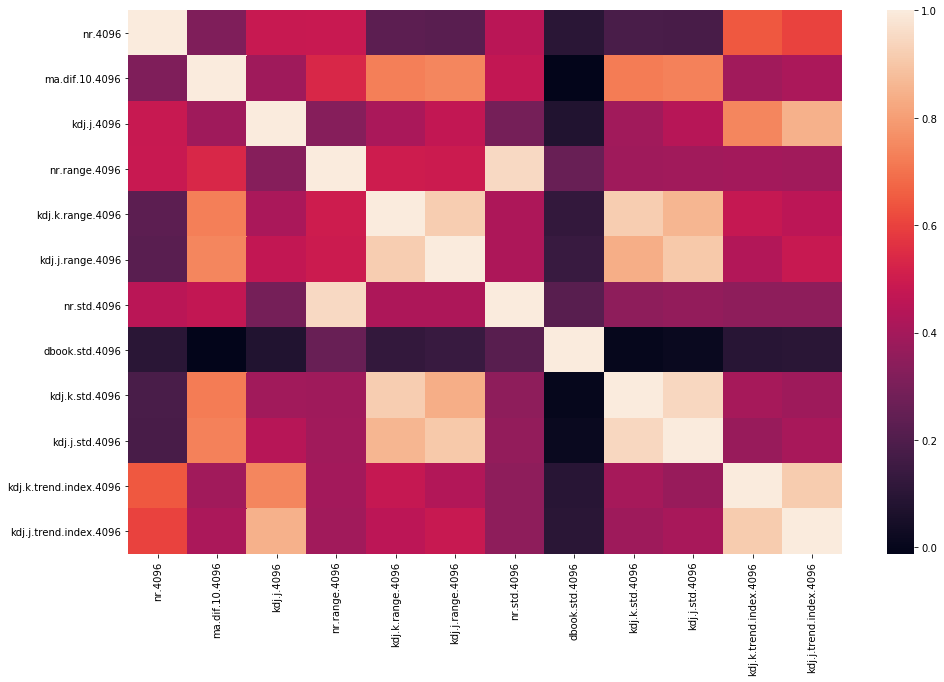

In [454]:
import seaborn as sns
plt.figure(figsize=(16,10)) 
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns);

- we can see that some of them has very high correlation

- we can add each signal one by one to a model and check how the performance envolves

In [455]:
np.argmax(np.abs(t_stat))
## [1] 7

7

In [456]:
signal_list[np.argmax(np.abs(t_stat))]
## 'nr.range.4096'

'nr.range.4096'

- the first signal is the signal dbook.std.4096


- to select the second signal, we can use forward selction

In [457]:
import statsmodels.formula.api as smf

## forward selection of signals
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    chosen_signals = []
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} - 1".format("data['"+response+"']",
                                           ' + '.join(selected + ["data['"+candidate+"']"]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append("data['"+best_candidate+"']")
            current_score = best_new_score
            chosen_signals.append(best_candidate)
    formula = "{} ~ {} - 1".format("data['"+response+"']",
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return OrderedDict([("model", model), ("chosen.signals", chosen_signals)])

In [458]:
result = forward_selected(train_mat[train_mat.columns[:-3]], "ret."+str(period))

In [459]:
save(result, HEAD_PATH+"/crypto_all_forwatd_select.pkl")

In [460]:
result = load(HEAD_PATH+"/crypto_all_forwatd_select.pkl");

In [461]:
result["model"].model.formula
# "data['ret.4096'] ~ data['nr.range.4096'] + data['kdj.j.range.4096'] + data['range.pos.range.4096'] + data['ma.dif.10.range.4096'] + data['ma.dif.10.4096'] + data['ma.dif.10.trend.index.4096'] + data['ma.dif.10.std.4096'] + data['range.pos.std.4096'] + data['kdj.j.std.4096'] + data['range.pos.4096'] + data['range.pos.trend.index.4096'] + data['nr.4096'] + data['nr.trend.index.4096'] + data['kdj.k.std.4096'] + data['price.osci.std.4096'] + data['price.osci.range.4096'] + data['kdj.k.range.4096'] + data['kdj.j.4096'] + data['kdj.j.trend.index.4096'] - 1"

"data['ret.4096'] ~ data['nr.range.4096'] + data['kdj.j.range.4096'] + data['range.pos.range.4096'] + data['ma.dif.10.range.4096'] + data['ma.dif.10.4096'] + data['ma.dif.10.trend.index.4096'] + data['ma.dif.10.std.4096'] + data['range.pos.std.4096'] + data['kdj.j.std.4096'] + data['range.pos.4096'] + data['range.pos.trend.index.4096'] + data['nr.4096'] + data['nr.trend.index.4096'] + data['kdj.k.std.4096'] + data['price.osci.std.4096'] + data['price.osci.range.4096'] + data['kdj.k.range.4096'] + data['kdj.j.4096'] + data['kdj.j.trend.index.4096'] - 1"

In [462]:
result["chosen.signals"]

# ['nr.range.4096',
#  'kdj.j.range.4096',
#  'range.pos.range.4096',
#  'ma.dif.10.range.4096',
#  'ma.dif.10.4096',
#  'ma.dif.10.trend.index.4096',
#  'ma.dif.10.std.4096',
#  'range.pos.std.4096',
#  'kdj.j.std.4096',
#  'range.pos.4096',
#  'range.pos.trend.index.4096',
#  'nr.4096',
#  'nr.trend.index.4096',
#  'kdj.k.std.4096',
#  'price.osci.std.4096',
#  'price.osci.range.4096',
#  'kdj.k.range.4096',
#  'kdj.j.4096',
#  'kdj.j.trend.index.4096']

['nr.range.4096',
 'kdj.j.range.4096',
 'range.pos.range.4096',
 'ma.dif.10.range.4096',
 'ma.dif.10.4096',
 'ma.dif.10.trend.index.4096',
 'ma.dif.10.std.4096',
 'range.pos.std.4096',
 'kdj.j.std.4096',
 'range.pos.4096',
 'range.pos.trend.index.4096',
 'nr.4096',
 'nr.trend.index.4096',
 'kdj.k.std.4096',
 'price.osci.std.4096',
 'price.osci.range.4096',
 'kdj.k.range.4096',
 'kdj.j.4096',
 'kdj.j.trend.index.4096']

- now we can check each model to see how the pnl evolves


- we can also get the test signals


- we can get the test samples first

In [463]:
%%time
for product in product_list[0:2]:
    print(product)
    daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")
    test_mat = get_sample_signal(all_dates, test_sample, product, 
                                  np.append(signal_list, ["ret."+str(period),  "ret."+str(period)+".001","ret."+str(period)+".002","ret."+str(period)+".004"]), 
                                  period, daily_num)
    os.makedirs(HEAD_PATH+"/train test mat/"+product, exist_ok=True)
    save(test_mat, HEAD_PATH+"/train test mat/"+product+".test.mat.pkl")
    
# btc.usd.td
# eth.usd.td
# Wall time: 5min 50s




btc.usd.td
eth.usd.td
Wall time: 5min 50s


- now let's fit the first model

In [468]:
first_signal = "nr.range."+str(period)
y_signal = "ret."+str(period)
formula = "train_mat['" + y_signal+"'] ~ train_mat['"+first_signal+"']+0"
formula

# "train_mat['ret.4096'] ~ train_mat['nr.range.4096.4096']+0"

"train_mat['ret.4096'] ~ train_mat['nr.range.4096']+0"

In [469]:
fit1_lm = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-3]]).fit()
print(fit1_lm.summary())

#  OLS Regression Results                                  
# ==========================================================================================
# Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.003
# Model:                               OLS   Adj. R-squared (uncentered):              0.003
# Method:                    Least Squares   F-statistic:                              22.19
# Date:                   Fri, 17 Jul 2020   Prob (F-statistic):                    2.51e-06
# Time:                           14:45:28   Log-Likelihood:                         -11726.
# No. Observations:                   8271   AIC:                                  2.345e+04
# Df Residuals:                       8270   BIC:                                  2.346e+04
# Df Model:                              1                                                  
# Covariance Type:               nonrobust                                                  
# ==============================================================================================
#                                  coef    std err          t      P>|t|      [0.025      0.975]
# ----------------------------------------------------------------------------------------------
# train_mat['nr.range.4096']     0.0517      0.011      4.711      0.000       0.030       0.073
# ==============================================================================
# Omnibus:                     2317.518   Durbin-Watson:                   2.072
# Prob(Omnibus):                  0.000   Jarque-Bera (JB):           263873.892
# Skew:                          -0.137   Prob(JB):                         0.00
# Kurtosis:                      30.670   Cond. No.                         1.00
# ==============================================================================

# Warnings:
# [1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

                                  OLS Regression Results                                  
Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.003
Model:                               OLS   Adj. R-squared (uncentered):              0.003
Method:                    Least Squares   F-statistic:                              22.19
Date:                   Fri, 17 Jul 2020   Prob (F-statistic):                    2.51e-06
Time:                           14:45:28   Log-Likelihood:                         -11726.
No. Observations:                   8271   AIC:                                  2.345e+04
Df Residuals:                       8270   BIC:                                  2.346e+04
Df Model:                              1                                                  
Covariance Type:               nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.025      0.

- we can see that the single R-square is already 0.0005814431935065034


- now we want to get the prediction value

In [470]:
strat = "one."+str(period)

- create a directory for the first strate

In [471]:
for product in product_list:
    os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

- we get the coefficiton of fit1.lm

In [472]:
fit_coef = fit1_lm.params.values
fit_coef
# array([0.05172867])

array([0.05172867])

- but since we have standardize the training samples before regrssion
- we must revert the result to original scale

In [473]:
train_std = dict([])
for product in product_list[0:2]:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    train_std[product] = np.std(cur_mat)

In [474]:
coef = fit_coef*train_std[product_list[0]][y_signal]/train_std[product_list[0]][first_signal]
coef
## array([7.62551508e-05])

array([7.62551508e-05])

In [475]:
%%time
for product in product_list[:2]:
    coef = fit_coef*train_std[product][y_signal]/train_std[product][first_signal]
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=[first_signal], coef=coef, strat=strat, HEAD_PATH=SAVE_PATH)
;

## Wall time: 

Wall time: 25.4 s


''

In [476]:
%%time
for product in product_list[:2]:
    par_get_all_signal("one.4096", all_dates, product, 4096, SAVE_PATH=SAVE_PATH)
## Wall time:19.3 s

Wall time: 19.3 s


In [483]:
%%time
for product in product_list[:2]:
    spread = product_info[product]["spread"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    tranct = product_info[product]["tranct"]
    evaluate_signal("one", all_dates, product, 2/spread, 20,
                    CORE_NUM,  HEAD_PATH, SAVE_PATH, period=4096, split_str="2019-08", tranct=tranct, 
                    max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=20/spread, save_path="signal result atr",reverse=1)

# reverse=1
# reverse=1
# Wall time: 7min 58s


reverse=1
reverse=1
Wall time: 7min 58s


In [487]:
for product in product_list[:2]:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+"one.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>4*spread)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

# btc.usd.td train sharpe  0.8872337683409721 test sharpe  1.3642827566582307
# eth.usd.td train sharpe  0.09714894595903997 test sharpe  1.608872168608774



btc.usd.td train sharpe  0.8872337683409721 test sharpe  1.3642827566582307
eth.usd.td train sharpe  0.09714894595903997 test sharpe  1.608872168608774


- then we work similar to previous common signals

- now we try to add a few new signal

In [488]:
y_signal = "ret."+str(period)
formula = "train_mat['" + y_signal+"'] ~ "
n_signal = int(len(result["chosen.signals"])/2)
for signal in result["chosen.signals"][:n_signal]:
    formula = formula+"+train_mat['"+signal+"']"
formula+="+0"
formula

## "train_mat['ret.4096'] ~ +train_mat['nr.range.4096']+train_mat['kdj.j.range.4096']+train_mat['range.pos.range.4096']+train_mat['ma.dif.10.range.4096']+train_mat['ma.dif.10.4096']+train_mat['ma.dif.10.trend.index.4096']+train_mat['ma.dif.10.std.4096']+train_mat['range.pos.std.4096']+train_mat['kdj.j.std.4096']+0"

"train_mat['ret.4096'] ~ +train_mat['nr.range.4096']+train_mat['kdj.j.range.4096']+train_mat['range.pos.range.4096']+train_mat['ma.dif.10.range.4096']+train_mat['ma.dif.10.4096']+train_mat['ma.dif.10.trend.index.4096']+train_mat['ma.dif.10.std.4096']+train_mat['range.pos.std.4096']+train_mat['kdj.j.std.4096']+0"

In [489]:
fit_half_lm  = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-3]]).fit()
print(fit_half_lm.summary())

#   OLS Regression Results                                  
# ==========================================================================================
# Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.026
# Model:                               OLS   Adj. R-squared (uncentered):              0.025
# Method:                    Least Squares   F-statistic:                              24.89
# Date:                   Fri, 17 Jul 2020   Prob (F-statistic):                    1.21e-42
# Time:                           15:08:49   Log-Likelihood:                         -11626.
# No. Observations:                   8271   AIC:                                  2.327e+04
# Df Residuals:                       8262   BIC:                                  2.333e+04
# Df Model:                              9                                                  
# Covariance Type:               nonrobust                                                  
# ===========================================================================================================
#                                               coef    std err          t      P>|t|      [0.025      0.975]
# -----------------------------------------------------------------------------------------------------------
# train_mat['nr.range.4096']                  0.0967      0.014      6.923      0.000       0.069       0.124
# train_mat['kdj.j.range.4096']               0.2858      0.096      2.975      0.003       0.098       0.474
# train_mat['range.pos.range.4096']          -0.4232      0.094     -4.487      0.000      -0.608      -0.238
# train_mat['ma.dif.10.range.4096']           0.0882      0.034      2.568      0.010       0.021       0.156
# train_mat['ma.dif.10.4096']                -0.0988      0.031     -3.138      0.002      -0.161      -0.037
# train_mat['ma.dif.10.trend.index.4096']     0.0350      0.036      0.967      0.334      -0.036       0.106
# train_mat['ma.dif.10.std.4096']             0.0406      0.036      1.128      0.260      -0.030       0.111
# train_mat['range.pos.std.4096']             0.6785      0.098      6.909      0.000       0.486       0.871
# train_mat['kdj.j.std.4096']                -0.6751      0.106     -6.385      0.000      -0.882      -0.468
# ==============================================================================
# Omnibus:                     2280.531   Durbin-Watson:                   2.020
# Prob(Omnibus):                  0.000   Jarque-Bera (JB):           256490.348
# Skew:                          -0.009   Prob(JB):                         0.00
# Kurtosis:                      30.281   Cond. No.                         45.8
# ==============================================================================

# Warnings:
# [1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

                                  OLS Regression Results                                  
Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.026
Model:                               OLS   Adj. R-squared (uncentered):              0.025
Method:                    Least Squares   F-statistic:                              24.89
Date:                   Fri, 17 Jul 2020   Prob (F-statistic):                    1.21e-42
Time:                           15:08:49   Log-Likelihood:                         -11626.
No. Observations:                   8271   AIC:                                  2.327e+04
Df Residuals:                       8262   BIC:                                  2.333e+04
Df Model:                              9                                                  
Covariance Type:               nonrobust                                                  
                                              coef    std err          t      P>|t|      [

In [494]:
strat = "half."+str(period)
fit_coef = fit_half_lm.params.values
fit_coef
# array([ 0.0967119 ,  0.2857779 , -0.42321829,  0.08819251, -0.09879853,
#        0.03501592,  0.0405621 ,  0.67854655, -0.67507806])

array([ 0.0967119 ,  0.2857779 , -0.42321829,  0.08819251, -0.09879853,
        0.03501592,  0.0405621 ,  0.67854655, -0.67507806])

In [491]:
train_std_mat = dict([])
for product in product_list[0:2]:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    train_std_mat[product] = np.std(cur_mat)

In [492]:
for product in product_list:
    os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

In [495]:
%%time
for product in product_list[0:2]:
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][result["chosen.signals"][:n_signal]]
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=result["chosen.signals"][:n_signal], coef=coef, strat=strat, HEAD_PATH=SAVE_PATH)
;
# Wall time:  39.1 s

Wall time: 39.1 s


''

In [496]:
%%time
for product in product_list[0:2]:
    par_get_all_signal("half.4096", all_dates, product, 4096, SAVE_PATH="e:/intern")
## Wall time: 19.1 s

Wall time: 19.1 s


In [498]:
%%time
SAVE_PATH = "e:/intern"
for product in product_list[0:2]:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    evaluate_signal("half", all_dates, product, 2/spread, 20, 
                    CORE_NUM, HEAD_PATH, SAVE_PATH, period=4096, split_str="2019-08", tranct=tranct, 
                    max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=20, save_path="signal result atr",reverse=1)

# reverse=1
# reverse=1
# Wall time: 6min 48s




reverse=1
reverse=1
Wall time: 6min 48s


In [499]:
for product in product_list[0:2]:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+"half.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>20*spread)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

# btc.usd.td train sharpe  0.7477602615605319 test sharpe  1.9032273456451958
# eth.usd.td train sharpe  1.9692384805514236 test sharpe  2.3756441832072936





btc.usd.td train sharpe  0.7477602615605319 test sharpe  1.9032273456451958
eth.usd.td train sharpe  1.9692384805514236 test sharpe  2.3756441832072936


In [500]:
y_signal = "ret."+str(period)
formula = "train_mat['" + y_signal+"'] ~ "
for signal in result["chosen.signals"]:
    formula = formula+"+train_mat['"+signal+"']"
formula+="+0"
formula

# "train_mat['ret.4096'] ~ +train_mat['nr.range.4096']+train_mat['kdj.j.range.4096']+train_mat['range.pos.range.4096']+train_mat['ma.dif.10.range.4096']+train_mat['ma.dif.10.4096']+train_mat['ma.dif.10.trend.index.4096']+train_mat['ma.dif.10.std.4096']+train_mat['range.pos.std.4096']+train_mat['kdj.j.std.4096']+train_mat['range.pos.4096']+train_mat['range.pos.trend.index.4096']+train_mat['nr.4096']+train_mat['nr.trend.index.4096']+train_mat['kdj.k.std.4096']+train_mat['price.osci.std.4096']+train_mat['price.osci.range.4096']+train_mat['kdj.k.range.4096']+train_mat['kdj.j.4096']+train_mat['kdj.j.trend.index.4096']+0"

"train_mat['ret.4096'] ~ +train_mat['nr.range.4096']+train_mat['kdj.j.range.4096']+train_mat['range.pos.range.4096']+train_mat['ma.dif.10.range.4096']+train_mat['ma.dif.10.4096']+train_mat['ma.dif.10.trend.index.4096']+train_mat['ma.dif.10.std.4096']+train_mat['range.pos.std.4096']+train_mat['kdj.j.std.4096']+train_mat['range.pos.4096']+train_mat['range.pos.trend.index.4096']+train_mat['nr.4096']+train_mat['nr.trend.index.4096']+train_mat['kdj.k.std.4096']+train_mat['price.osci.std.4096']+train_mat['price.osci.range.4096']+train_mat['kdj.k.range.4096']+train_mat['kdj.j.4096']+train_mat['kdj.j.trend.index.4096']+0"

- now we look at the full model

In [502]:
fit_full_lm  = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-3]]).fit()
print(fit_full_lm.summary())

#   OLS Regression Results                                  
# ==========================================================================================
# Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.031
# Model:                               OLS   Adj. R-squared (uncentered):              0.029
# Method:                    Least Squares   F-statistic:                              13.98
# Date:                   Fri, 17 Jul 2020   Prob (F-statistic):                    1.32e-44
# Time:                           15:34:32   Log-Likelihood:                         -11606.
# No. Observations:                   8271   AIC:                                  2.325e+04
# Df Residuals:                       8252   BIC:                                  2.338e+04
# Df Model:                             19                                                  
# Covariance Type:               nonrobust                                                  
# ===========================================================================================================
#                                               coef    std err          t      P>|t|      [0.025      0.975]
# -----------------------------------------------------------------------------------------------------------
# train_mat['nr.range.4096']                  0.0819      0.016      5.024      0.000       0.050       0.114
# train_mat['kdj.j.range.4096']               0.6914      0.173      4.005      0.000       0.353       1.030
# train_mat['range.pos.range.4096']          -0.5554      0.106     -5.255      0.000      -0.763      -0.348
# train_mat['ma.dif.10.range.4096']           0.0336      0.040      0.842      0.400      -0.045       0.112
# train_mat['ma.dif.10.4096']                -0.2123      0.047     -4.486      0.000      -0.305      -0.120
# train_mat['ma.dif.10.trend.index.4096']     0.1377      0.045      3.069      0.002       0.050       0.226
# train_mat['ma.dif.10.std.4096']             0.1248      0.041      3.070      0.002       0.045       0.204
# train_mat['range.pos.std.4096']             0.8097      0.107      7.585      0.000       0.600       1.019
# train_mat['kdj.j.std.4096']                -1.1905      0.201     -5.914      0.000      -1.585      -0.796
# train_mat['range.pos.4096']                 0.1425      0.055      2.608      0.009       0.035       0.250
# train_mat['range.pos.trend.index.4096']    -0.1147      0.056     -2.044      0.041      -0.225      -0.005
# train_mat['nr.4096']                        0.0688      0.030      2.313      0.021       0.010       0.127
# train_mat['nr.trend.index.4096']           -0.0529      0.031     -1.696      0.090      -0.114       0.008
# train_mat['kdj.k.std.4096']                 0.4150      0.152      2.735      0.006       0.118       0.712
# train_mat['price.osci.std.4096']           -0.2627      0.070     -3.757      0.000      -0.400      -0.126
# train_mat['price.osci.range.4096']          0.2381      0.070      3.384      0.001       0.100       0.376
# train_mat['kdj.k.range.4096']              -0.2784      0.119     -2.331      0.020      -0.513      -0.044
# train_mat['kdj.j.4096']                    -0.0902      0.056     -1.606      0.108      -0.200       0.020
# train_mat['kdj.j.trend.index.4096']         0.0592      0.057      1.044      0.296      -0.052       0.170
# ==============================================================================
# Omnibus:                     2268.577   Durbin-Watson:                   2.023
# Prob(Omnibus):                  0.000   Jarque-Bera (JB):           248489.060
# Skew:                           0.028   Prob(JB):                         0.00
# Kurtosis:                      29.852   Cond. No.                         102.
# ==============================================================================

# Warnings:
# [1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

                                  OLS Regression Results                                  
Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.031
Model:                               OLS   Adj. R-squared (uncentered):              0.029
Method:                    Least Squares   F-statistic:                              13.98
Date:                   Fri, 17 Jul 2020   Prob (F-statistic):                    1.32e-44
Time:                           15:34:32   Log-Likelihood:                         -11606.
No. Observations:                   8271   AIC:                                  2.325e+04
Df Residuals:                       8252   BIC:                                  2.338e+04
Df Model:                             19                                                  
Covariance Type:               nonrobust                                                  
                                              coef    std err          t      P>|t|      [

In [503]:
strat = "full."+str(period)
os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)
fit_coef = fit_full_lm.params.values
fit_coef

# array([ 0.0819258 ,  0.6913957 , -0.55538852,  0.03359954, -0.21232737,
#         0.13766156,  0.12479479,  0.80972414, -1.19048928,  0.14254266,
#        -0.11468121,  0.06877016, -0.05289568,  0.41497584, -0.26265315,
#         0.23805662, -0.27841224, -0.09016691,  0.05924329])

array([ 0.0819258 ,  0.6913957 , -0.55538852,  0.03359954, -0.21232737,
        0.13766156,  0.12479479,  0.80972414, -1.19048928,  0.14254266,
       -0.11468121,  0.06877016, -0.05289568,  0.41497584, -0.26265315,
        0.23805662, -0.27841224, -0.09016691,  0.05924329])

In [504]:
for product in product_list:
    os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

In [505]:
%%time
for product in product_list[0:2]:
    print(product)
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][result["chosen.signals"]]
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=result["chosen.signals"], coef=coef, strat="full.4096", HEAD_PATH=SAVE_PATH)
    
# btc.usd.td
# eth.usd.td
# Wall time: 53.8 s



btc.usd.td
eth.usd.td
Wall time: 53.8 s


In [506]:
%%time
for product in product_list[0:2]:
    par_get_all_signal("full.4096", all_dates, product, 4096, SAVE_PATH=SAVE_PATH)
## Wall time: 19 s



Wall time: 19 s


In [508]:
%%time
for product in product_list[0:2]:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"] 
    evaluate_signal("full", all_dates, product, 2/spread, 20, 
                    CORE_NUM, HEAD_PATH, SAVE_PATH,period=4096, split_str="2019-08", tranct=tranct, 
                    max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=20, save_path="signal result atr",reverse=1)

# reverse=1
# reverse=1
# Wall time: 6min 38s



reverse=1
reverse=1
Wall time: 6min 38s


In [580]:
for product in product_list[0:2]:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+"full.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>20*spread)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

# btc.usd.td train sharpe  1.1037680618652521 test sharpe  1.3454173676985408
# eth.usd.td train sharpe  1.4379465510171268 test sharpe  1.4629342214138616




btc.usd.td train sharpe  0.5829362859003242 test sharpe  2.074490735190875
eth.usd.td train sharpe  1.7872907518663508 test sharpe  3.5647759134417827


In [513]:
y_signal = "ret."+str(period)+".004"
formula = "train_mat['" + y_signal+"'] ~ "
for signal in result["chosen.signals"]:
    formula = formula+"+train_mat['"+signal+"']"
formula+="+0"
formula

## "train_mat['ret.4096.004'] ~ +train_mat['nr.range.4096']+train_mat['kdj.j.range.4096']+train_mat['range.pos.range.4096']+train_mat['ma.dif.10.range.4096']+train_mat['ma.dif.10.4096']+train_mat['ma.dif.10.trend.index.4096']+train_mat['ma.dif.10.std.4096']+train_mat['range.pos.std.4096']+train_mat['kdj.j.std.4096']+train_mat['range.pos.4096']+train_mat['range.pos.trend.index.4096']+train_mat['nr.4096']+train_mat['nr.trend.index.4096']+train_mat['kdj.k.std.4096']+train_mat['price.osci.std.4096']+train_mat['price.osci.range.4096']+train_mat['kdj.k.range.4096']+train_mat['kdj.j.4096']+train_mat['kdj.j.trend.index.4096']+0"

"train_mat['ret.4096.004'] ~ +train_mat['nr.range.4096']+train_mat['kdj.j.range.4096']+train_mat['range.pos.range.4096']+train_mat['ma.dif.10.range.4096']+train_mat['ma.dif.10.4096']+train_mat['ma.dif.10.trend.index.4096']+train_mat['ma.dif.10.std.4096']+train_mat['range.pos.std.4096']+train_mat['kdj.j.std.4096']+train_mat['range.pos.4096']+train_mat['range.pos.trend.index.4096']+train_mat['nr.4096']+train_mat['nr.trend.index.4096']+train_mat['kdj.k.std.4096']+train_mat['price.osci.std.4096']+train_mat['price.osci.range.4096']+train_mat['kdj.k.range.4096']+train_mat['kdj.j.4096']+train_mat['kdj.j.trend.index.4096']+0"

In [514]:
fit_004_lm  = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-3]]).fit()
strat = "full.004."+str(period)
for product in product_list:
    os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)
fit_coef = fit_004_lm.params.values
fit_coef

# array([ 0.0396801 ,  0.17703614, -0.07385492,  0.11547512, -0.08682319,
#         0.06838427, -0.0231813 ,  0.21668915, -0.49848164,  0.11737424,
#        -0.05986007,  0.073747  , -0.05215649,  0.26189336, -0.01052209,
#        -0.04267964, -0.15418542, -0.09866202,  0.02525946])

array([ 0.0396801 ,  0.17703614, -0.07385492,  0.11547512, -0.08682319,
        0.06838427, -0.0231813 ,  0.21668915, -0.49848164,  0.11737424,
       -0.05986007,  0.073747  , -0.05215649,  0.26189336, -0.01052209,
       -0.04267964, -0.15418542, -0.09866202,  0.02525946])

In [517]:
%%time
for product in product_list[0:2]:
    print(product)
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][result["chosen.signals"]]
    print(coef)
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=result["chosen.signals"], 
              coef=coef, strat=strat, HEAD_PATH=SAVE_PATH)
    
# IF
# trade.imb.std.4096                 -0.001920
# trade.imb.volume.open.ratio.4096    0.017469
# kdj.k.trend.index.4096              0.000248
# kdj.j.range.4096                    0.000062
# price.osci.std.4096                 0.000818
# ma.dif.10.std.4096                 -0.013392
# price.osci.4096                    -0.000799
# total.trade.imb.range.4096         -0.000157
# price.osci.range.4096              -0.000103
# kdj.j.std.4096                     -0.000375
# trade.imb.range.4096                0.000463
# dtype: float64
# IH
# trade.imb.std.4096                 -0.004314
# trade.imb.volume.open.ratio.4096    0.017410
# kdj.k.trend.index.4096              0.000274
# kdj.j.range.4096                    0.000092
# price.osci.std.4096                 0.001229
# ma.dif.10.std.4096                 -0.019589
# price.osci.4096                    -0.000899
# total.trade.imb.range.4096         -0.000277
# price.osci.range.4096              -0.000155
# kdj.j.std.4096                     -0.000539
# trade.imb.range.4096                0.001066
# dtype: float64
# IC
# trade.imb.std.4096                 -0.000963
# trade.imb.volume.open.ratio.4096    0.020816
# kdj.k.trend.index.4096              0.000320
# kdj.j.range.4096                    0.000033
# price.osci.std.4096                 0.000431
# ma.dif.10.std.4096                 -0.004773
# price.osci.4096                    -0.001010
# total.trade.imb.range.4096         -0.000084
# price.osci.range.4096              -0.000055
# kdj.j.std.4096                     -0.000192
# trade.imb.range.4096                0.000261
# dtype: float64
# Wall time: 1min 21s

btc.usd.td
nr.range.4096                 0.000048
kdj.j.range.4096              0.000031
range.pos.range.4096         -0.000040
ma.dif.10.range.4096          0.000460
ma.dif.10.4096               -0.104258
ma.dif.10.trend.index.4096    0.129901
ma.dif.10.std.4096           -0.000264
range.pos.std.4096            0.000419
kdj.j.std.4096               -0.000294
range.pos.4096                0.005358
range.pos.trend.index.4096   -0.004505
nr.4096                       0.004399
nr.trend.index.4096          -0.004118
kdj.k.std.4096                0.000133
price.osci.std.4096          -0.000007
price.osci.range.4096        -0.000007
kdj.k.range.4096             -0.000023
kdj.j.4096                   -0.001365
kdj.j.trend.index.4096        0.000563
dtype: float64
eth.usd.td
nr.range.4096                 0.001160
kdj.j.range.4096              0.000659
range.pos.range.4096         -0.000887
ma.dif.10.range.4096          0.002264
ma.dif.10.4096               -0.063552
ma.dif.10.trend.index.4096 

In [518]:
%%time
for product in product_list[0:2]:
    par_get_all_signal("full.004.4096", all_dates, product, 4096)

## Wall time: 26.9 s

Wall time: 19 s


In [519]:
%%time
for product in product_list[0:2]:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"] 
    evaluate_signal("full.004", all_dates, product, 2/spread, 20, 
                    CORE_NUM, HEAD_PATH, SAVE_PATH,period=4096, split_str="2019-08", tranct=tranct, 
                    max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=20, save_path="signal result atr",reverse=1)
    
# reverse=1
# reverse=1
# Wall time: 6min 12s



reverse=1
reverse=1
Wall time: 6min 12s


In [581]:
for product in product_list[0:2]:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+"full.004.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>20*spread)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    train_std = np.std(train_pnl)
    train_pnl = train_pnl/train_std
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)/train_std
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

# btc.usd.td train sharpe  1.8813772728277425 test sharpe  1.6576743822780142
# eth.usd.td train sharpe  2.240158619352697 test sharpe  2.559491086488319





btc.usd.td train sharpe  1.8813772728277425 test sharpe  1.6576743822780142
eth.usd.td train sharpe  2.240158619352697 test sharpe  2.559491086488319


In [521]:
y_signal = "ret."+str(period)+".002"
formula = "train_mat['" + y_signal+"'] ~ "
for signal in result["chosen.signals"]:
    formula = formula+"+train_mat['"+signal+"']"
formula+="+0"
formula
# "train_mat['ret.4096.002'] ~ +train_mat['nr.range.4096']+train_mat['kdj.j.range.4096']+train_mat['range.pos.range.4096']+train_mat['ma.dif.10.range.4096']+train_mat['ma.dif.10.4096']+train_mat['ma.dif.10.trend.index.4096']+train_mat['ma.dif.10.std.4096']+train_mat['range.pos.std.4096']+train_mat['kdj.j.std.4096']+train_mat['range.pos.4096']+train_mat['range.pos.trend.index.4096']+train_mat['nr.4096']+train_mat['nr.trend.index.4096']+train_mat['kdj.k.std.4096']+train_mat['price.osci.std.4096']+train_mat['price.osci.range.4096']+train_mat['kdj.k.range.4096']+train_mat['kdj.j.4096']+train_mat['kdj.j.trend.index.4096']+0"

"train_mat['ret.4096.002'] ~ +train_mat['nr.range.4096']+train_mat['kdj.j.range.4096']+train_mat['range.pos.range.4096']+train_mat['ma.dif.10.range.4096']+train_mat['ma.dif.10.4096']+train_mat['ma.dif.10.trend.index.4096']+train_mat['ma.dif.10.std.4096']+train_mat['range.pos.std.4096']+train_mat['kdj.j.std.4096']+train_mat['range.pos.4096']+train_mat['range.pos.trend.index.4096']+train_mat['nr.4096']+train_mat['nr.trend.index.4096']+train_mat['kdj.k.std.4096']+train_mat['price.osci.std.4096']+train_mat['price.osci.range.4096']+train_mat['kdj.k.range.4096']+train_mat['kdj.j.4096']+train_mat['kdj.j.trend.index.4096']+0"

In [522]:
fit_002_lm  = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-2]]).fit()
strat = "full.002."+str(period)
for product in product_list:
    os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)
fit_coef = fit_002_lm.params.values
fit_coef

# array([ 0.05854297,  0.24742786, -0.15695334,  0.01213161, -0.12177005,
#         0.08192567,  0.11131216,  0.28881354, -0.50034906,  0.13110896,
#        -0.05101417,  0.0331438 , -0.02013604,  0.19290853, -0.0455401 ,
#        -0.05032785, -0.1187902 , -0.12134613,  0.00987017])

array([ 0.05854297,  0.24742786, -0.15695334,  0.01213161, -0.12177005,
        0.08192567,  0.11131216,  0.28881354, -0.50034906,  0.13110896,
       -0.05101417,  0.0331438 , -0.02013604,  0.19290853, -0.0455401 ,
       -0.05032785, -0.1187902 , -0.12134613,  0.00987017])

In [523]:
%%time
for product in product_list[0:2]:
    print(product)
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][result["chosen.signals"]]
    print(coef)
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=result["chosen.signals"], 
              coef=coef, strat=strat, HEAD_PATH=SAVE_PATH)
;

# btc.usd.td
# nr.range.4096                 0.000057
# kdj.j.range.4096              0.000035
# range.pos.range.4096         -0.000069
# ma.dif.10.range.4096          0.000039
# ma.dif.10.4096               -0.117456
# ma.dif.10.trend.index.4096    0.125007
# ma.dif.10.std.4096            0.001019
# range.pos.std.4096            0.000449
# kdj.j.std.4096               -0.000237
# range.pos.4096                0.004808
# range.pos.trend.index.4096   -0.003084
# nr.4096                       0.001588
# nr.trend.index.4096          -0.001277
# kdj.k.std.4096                0.000079
# price.osci.std.4096          -0.000024
# price.osci.range.4096        -0.000007
# kdj.k.range.4096             -0.000014
# kdj.j.4096                   -0.001348
# kdj.j.trend.index.4096        0.000177
# dtype: float64
# eth.usd.td
# nr.range.4096                 0.001283
# kdj.j.range.4096              0.000690
# range.pos.range.4096         -0.001414
# ma.dif.10.range.4096          0.000178
# ma.dif.10.4096               -0.066815
# ma.dif.10.trend.index.4096    0.058920
# ma.dif.10.std.4096            0.003765
# range.pos.std.4096            0.007855
# kdj.j.std.4096               -0.004057
# range.pos.4096                0.006376
# range.pos.trend.index.4096   -0.004305
# nr.4096                       0.002930
# nr.trend.index.4096          -0.002578
# kdj.k.std.4096                0.001215
# price.osci.std.4096          -0.000345
# price.osci.range.4096        -0.000127
# kdj.k.range.4096             -0.000270
# kdj.j.4096                   -0.001852
# kdj.j.trend.index.4096        0.000255
# dtype: float64
# Wall time: 53.3 s

btc.usd.td
nr.range.4096                 0.000057
kdj.j.range.4096              0.000035
range.pos.range.4096         -0.000069
ma.dif.10.range.4096          0.000039
ma.dif.10.4096               -0.117456
ma.dif.10.trend.index.4096    0.125007
ma.dif.10.std.4096            0.001019
range.pos.std.4096            0.000449
kdj.j.std.4096               -0.000237
range.pos.4096                0.004808
range.pos.trend.index.4096   -0.003084
nr.4096                       0.001588
nr.trend.index.4096          -0.001277
kdj.k.std.4096                0.000079
price.osci.std.4096          -0.000024
price.osci.range.4096        -0.000007
kdj.k.range.4096             -0.000014
kdj.j.4096                   -0.001348
kdj.j.trend.index.4096        0.000177
dtype: float64
eth.usd.td
nr.range.4096                 0.001283
kdj.j.range.4096              0.000690
range.pos.range.4096         -0.001414
ma.dif.10.range.4096          0.000178
ma.dif.10.4096               -0.066815
ma.dif.10.trend.index.4096 

''

- now we try the ret.4096.002 as response

In [524]:
%%time
for product in product_list[0:2]:
    par_get_all_signal("full.002.4096", all_dates, product, 4096)
    
## Wall time: 19.5 s


Wall time: 19.5 s


In [526]:
%%time
for product in product_list[0:2]:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"] 
    evaluate_signal("full.002", all_dates, product, 2/spread, 20, 
                    CORE_NUM, HEAD_PATH, SAVE_PATH,period=4096, split_str="2019-08", tranct=tranct, 
                    max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=20, save_path="signal result atr",reverse=1)
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# Wall time: 6min 57s

reverse=1
reverse=1
Wall time: 6min 57s


In [583]:
for product in product_list[0:2]:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+"full.002.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>20*spread)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

## full.002
# btc.usd.td train sharpe  2.55145720509238 test sharpe  1.3977493829932683
# eth.usd.td train sharpe  1.8577544491631366 test sharpe  -1.2868484139239404




btc.usd.td train sharpe  2.55145720509238 test sharpe  1.3977493829932683
eth.usd.td train sharpe  1.8577544491631366 test sharpe  -1.2868484139239404


- now we try to use ret.001

In [530]:
y_signal = "ret."+str(period)+".001"
formula = "train_mat['" + y_signal+"'] ~ "
for signal in result["chosen.signals"]:
    formula = formula+"+train_mat['"+signal+"']"
formula+="+0"
formula
fit_001_lm  = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-2]]).fit()
strat = "full.001."+str(period)
for product in product_list:
    os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)
fit_coef = fit_001_lm.params.values
fit_coef

# array([ 0.05710273, -0.11104159,  0.09803416,  0.09594221, -0.12784996,
#         0.04217033,  0.0114973 , -0.06177029,  0.13201518,  0.10336313,
#        -0.03149299,  0.004951  , -0.00827786, -0.05307445, -0.04493237,
#        -0.03812789, -0.01615294, -0.12274567,  0.00375508])

array([ 0.05710273, -0.11104159,  0.09803416,  0.09594221, -0.12784996,
        0.04217033,  0.0114973 , -0.06177029,  0.13201518,  0.10336313,
       -0.03149299,  0.004951  , -0.00827786, -0.05307445, -0.04493237,
       -0.03812789, -0.01615294, -0.12274567,  0.00375508])

In [531]:
%%time
for product in product_list[0:2]:
    print(product)
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][result["chosen.signals"]]
    print(coef)
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=result["chosen.signals"], 
              coef=coef, strat=strat, HEAD_PATH=SAVE_PATH)
;

# btc.usd.td
# nr.range.4096                 0.000040
# kdj.j.range.4096             -0.000011
# range.pos.range.4096          0.000031
# ma.dif.10.range.4096          0.000219
# ma.dif.10.4096               -0.088172
# ma.dif.10.trend.index.4096    0.046006
# ma.dif.10.std.4096            0.000075
# range.pos.std.4096           -0.000069
# kdj.j.std.4096                0.000045
# range.pos.4096                0.002710
# range.pos.trend.index.4096   -0.001361
# nr.4096                       0.000170
# nr.trend.index.4096          -0.000375
# kdj.k.std.4096               -0.000016
# price.osci.std.4096          -0.000017
# price.osci.range.4096        -0.000004
# kdj.k.range.4096             -0.000001
# kdj.j.4096                   -0.000975
# kdj.j.trend.index.4096        0.000048
# dtype: float64
# eth.usd.td
# nr.range.4096                 0.000833
# kdj.j.range.4096             -0.000206
# range.pos.range.4096          0.000588
# ma.dif.10.range.4096          0.000939
# ma.dif.10.4096               -0.046700
# ma.dif.10.trend.index.4096    0.020190
# ma.dif.10.std.4096            0.000259
# range.pos.std.4096           -0.001118
# kdj.j.std.4096                0.000713
# range.pos.4096                0.003346
# range.pos.trend.index.4096   -0.001769
# nr.4096                       0.000291
# nr.trend.index.4096          -0.000706
# kdj.k.std.4096               -0.000223
# price.osci.std.4096          -0.000227
# price.osci.range.4096        -0.000064
# kdj.k.range.4096             -0.000024
# kdj.j.4096                   -0.001247
# kdj.j.trend.index.4096        0.000065
# dtype: float64
# Wall time: 59.1 s

btc.usd.td
nr.range.4096                 0.000040
kdj.j.range.4096             -0.000011
range.pos.range.4096          0.000031
ma.dif.10.range.4096          0.000219
ma.dif.10.4096               -0.088172
ma.dif.10.trend.index.4096    0.046006
ma.dif.10.std.4096            0.000075
range.pos.std.4096           -0.000069
kdj.j.std.4096                0.000045
range.pos.4096                0.002710
range.pos.trend.index.4096   -0.001361
nr.4096                       0.000170
nr.trend.index.4096          -0.000375
kdj.k.std.4096               -0.000016
price.osci.std.4096          -0.000017
price.osci.range.4096        -0.000004
kdj.k.range.4096             -0.000001
kdj.j.4096                   -0.000975
kdj.j.trend.index.4096        0.000048
dtype: float64
eth.usd.td
nr.range.4096                 0.000833
kdj.j.range.4096             -0.000206
range.pos.range.4096          0.000588
ma.dif.10.range.4096          0.000939
ma.dif.10.4096               -0.046700
ma.dif.10.trend.index.4096 

''

In [532]:
%%time
for product in product_list[0:2]:
    par_get_all_signal("full.001.4096", all_dates, product, 4096)

## Wall time: 18.9 s

Wall time: 18.9 s


In [534]:
%%time
for product in product_list[0:2]:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"] 
    evaluate_signal("full.001", all_dates, product, 2/spread, 20, 
                    CORE_NUM, HEAD_PATH, SAVE_PATH,period=4096, split_str="2019-08", tranct=tranct, 
                    max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=20, save_path="signal result atr",reverse=1)
    
# reverse=1
# reverse=1
# Wall time: 6min 26s




reverse=1
reverse=1
Wall time: 6min 26s


In [582]:
%%time
for product in product_list[0:2]:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+"full.001.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>20*spread)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

## full.001
# btc.usd.td train sharpe  2.753761923083398 test sharpe  1.2567417470314899
# eth.usd.td train sharpe  1.9827871998468172 test sharpe  -1.1643027683149838

## full.002
# btc.usd.td train sharpe  2.485138801203194 test sharpe  1.4141024529125132
# eth.usd.td train sharpe  1.5714752653681243 test sharpe  -1.3368059017951117


## full.004
# btc.usd.td train sharpe  1.8813772728277425 test sharpe  1.6576743822780142
# eth.usd.td train sharpe  2.240158619352697 test sharpe  2.559491086488319


## original full
# IF train sharpe  0.4982541328255545 test sharpe  0.8939045222957637
# IH train sharpe  0.21747502986522438 test sharpe  0.19000986556739546
# IC train sharpe  0.5704744572663202 test sharpe  0.9975516857023627




btc.usd.td train sharpe  2.753761923083398 test sharpe  1.2567417470314899
eth.usd.td train sharpe  1.9827871998468172 test sharpe  -1.1643027683149838
Wall time: 25 ms


In [537]:

import statsmodels.formula.api as smf
def step_aic(model, exog, endog, **kwargs):
    """
    This select the best exogenous variables with AIC
    Both exog and endog values can be either str or list.
    (Endog list is for the Binomial family.)

    Note: This adopt only "forward" selection

    Args:
        model: model from statsmodels.formula.api
        exog (str or list): exogenous variables
        endog (str or list): endogenous variables
        kwargs: extra keyword argments for model (e.g., data, family)

    Returns:
        model: a model that seems to have the smallest AIC
    """
    for key in kwargs.keys():
        df = kwargs[key]
    df_name = "df"    
    remaining = set(exog)
    
    exog = [df_name+"['"+s+"']" for s in exog]
    endog = [df_name+"['"+s+"']" for s in endog]
    
        
    # exog, endogは強制的にリスト形式に変換しておく
    exog = np.r_[[exog]].flatten()
    endog = np.r_[[endog]].flatten()
    selected = []  # 採用が確定された要因
    chosen_signals = []
    # 定数項のみのAICを計算
    formula_head = ' + '.join(endog) + ' ~ '
    formula = formula_head + '1'
    #aic = model(formula=formula, **kwargs).fit().aic
    aic = model(formula=formula, data=df).fit().aic
    print('AIC: {}, formula: {}'.format(round(aic, 3), formula))

    current_score, best_new_score = np.ones(2) * aic

    # 全要因を採択するか，どの要因を追加してもAICが上がらなければ終了
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:

            # 残っている要因を1つずつ追加したときのAICを計算
            formula_tail = ' + '.join(selected + [df_name+"['"+candidate+"']"])
            formula = formula_head + formula_tail
            #aic = model(formula=formula, **kwargs).fit().aic
            aic = model(formula=formula, data=df).fit().aic
            print('AIC: {}, formula: {}'.format(round(aic, 3), formula))

            scores_with_candidates.append((aic, candidate))

        # 最もAICが小さかった要因をbest_candidateとする
        scores_with_candidates.sort()
        scores_with_candidates.reverse()
        best_new_score, best_candidate = scores_with_candidates.pop()

        # 候補要因追加でAICが下がったならば，それを確定要因として追加する
        
        if best_new_score < current_score:
            remaining.remove(best_candidate)
            selected.append(df_name+"['"+best_candidate+"']")
            chosen_signals.append(best_candidate)
            current_score = best_new_score

    formula = formula_head + ' + '.join(selected)
    print('The best formula: {}'.format(formula))
    #return model(formula, **kwargs).fit()
    result = OrderedDict([("model", model), ("chosen.signals", chosen_signals)])
    #return model(formula, data=df).fit()
    return result

In [538]:
fwd_model = step_aic(smf.ols, train_mat.columns[:-4], ["ret."+str(period)], data=train_mat)
## The best formula: The best formula: df['ret.4096'] ~ df['trade.imb.std.4096'] + df['trade.imb.4096']

AIC: 23474.376, formula: df['ret.4096'] ~ 1
AIC: 23470.283, formula: df['ret.4096'] ~ df['kdj.k.range.4096']
AIC: 23474.273, formula: df['ret.4096'] ~ df['dbook.4096']
AIC: 23472.952, formula: df['ret.4096'] ~ df['kdj.k.4096']
AIC: 23475.534, formula: df['ret.4096'] ~ df['nr.trend.index.4096']
AIC: 23471.069, formula: df['ret.4096'] ~ df['nr.4096']
AIC: 23469.043, formula: df['ret.4096'] ~ df['ma.dif.10.4096']
AIC: 23454.864, formula: df['ret.4096'] ~ df['nr.std.4096']
AIC: 23475.615, formula: df['ret.4096'] ~ df['price.osci.std.4096']
AIC: 23475.966, formula: df['ret.4096'] ~ df['dbook.trend.index.4096']
AIC: 23474.019, formula: df['ret.4096'] ~ df['range.pos.trend.index.4096']
AIC: 23473.276, formula: df['ret.4096'] ~ df['ma.dif.10.std.4096']
AIC: 23475.565, formula: df['ret.4096'] ~ df['dbook.range.4096']
AIC: 23466.195, formula: df['ret.4096'] ~ df['kdj.j.trend.index.4096']
AIC: 23476.354, formula: df['ret.4096'] ~ df['range.pos.4096']
AIC: 23475.446, formula: df['ret.4096'] ~ df['

In [543]:
y_signal = "ret."+str(period)
formula = "train_mat['" + y_signal+"'] ~ "
for signal in fwd_model["chosen.signals"]:
    formula = formula+"+train_mat['"+signal+"']"
formula+="+0"
formula
## "train_mat['ret.4096'] ~ +train_mat['nr.range.4096']+train_mat['kdj.j.range.4096']+train_mat['range.pos.range.4096']+train_mat['ma.dif.10.range.4096']+train_mat['ma.dif.10.4096']+train_mat['ma.dif.10.trend.index.4096']+train_mat['ma.dif.10.std.4096']+train_mat['range.pos.std.4096']+train_mat['kdj.j.std.4096']+train_mat['range.pos.4096']+train_mat['range.pos.trend.index.4096']+train_mat['nr.4096']+train_mat['nr.trend.index.4096']+0"



"train_mat['ret.4096'] ~ +train_mat['nr.range.4096']+train_mat['kdj.j.range.4096']+train_mat['range.pos.range.4096']+train_mat['ma.dif.10.range.4096']+train_mat['ma.dif.10.4096']+train_mat['ma.dif.10.trend.index.4096']+train_mat['ma.dif.10.std.4096']+train_mat['range.pos.std.4096']+train_mat['kdj.j.std.4096']+train_mat['range.pos.4096']+train_mat['range.pos.trend.index.4096']+train_mat['nr.4096']+train_mat['nr.trend.index.4096']+0"

In [544]:
formula
fit_lm  = smf.ols(formula=formula, data=train_mat[train_mat.columns]).fit()
print(fit_lm.summary())

#  OLS Regression Results                                  
# ==========================================================================================
# Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.029
# Model:                               OLS   Adj. R-squared (uncentered):              0.027
# Method:                    Least Squares   F-statistic:                              18.89
# Date:                   Fri, 17 Jul 2020   Prob (F-statistic):                    2.78e-44
# Time:                           17:42:11   Log-Likelihood:                         -11616.
# No. Observations:                   8271   AIC:                                  2.326e+04
# Df Residuals:                       8258   BIC:                                  2.335e+04
# Df Model:                             13                                                  
# Covariance Type:               nonrobust                                                  
# ===========================================================================================================
#                                               coef    std err          t      P>|t|      [0.025      0.975]
# -----------------------------------------------------------------------------------------------------------
# train_mat['nr.range.4096']                  0.0907      0.015      5.948      0.000       0.061       0.121
# train_mat['kdj.j.range.4096']               0.2953      0.096      3.060      0.002       0.106       0.484
# train_mat['range.pos.range.4096']          -0.3976      0.095     -4.201      0.000      -0.583      -0.212
# train_mat['ma.dif.10.range.4096']           0.0599      0.036      1.666      0.096      -0.011       0.130
# train_mat['ma.dif.10.4096']                -0.1521      0.034     -4.525      0.000      -0.218      -0.086
# train_mat['ma.dif.10.trend.index.4096']     0.0970      0.039      2.480      0.013       0.020       0.174
# train_mat['ma.dif.10.std.4096']             0.0737      0.037      1.971      0.049       0.000       0.147
# train_mat['range.pos.std.4096']             0.6449      0.098      6.552      0.000       0.452       0.838
# train_mat['kdj.j.std.4096']                -0.6884      0.107     -6.456      0.000      -0.897      -0.479
# train_mat['range.pos.4096']                 0.0708      0.022      3.151      0.002       0.027       0.115
# train_mat['range.pos.trend.index.4096']    -0.0718      0.026     -2.726      0.006      -0.124      -0.020
# train_mat['nr.4096']                        0.0740      0.029      2.593      0.010       0.018       0.130
# train_mat['nr.trend.index.4096']           -0.0570      0.030     -1.875      0.061      -0.117       0.003
# ==============================================================================
# Omnibus:                     2276.765   Durbin-Watson:                   2.020
# Prob(Omnibus):                  0.000   Jarque-Bera (JB):           254193.920
# Skew:                           0.004   Prob(JB):                         0.00
# Kurtosis:                      30.159   Cond. No.                         48.5
# ==============================================================================

# Warnings:
# [1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

                                  OLS Regression Results                                  
Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.029
Model:                               OLS   Adj. R-squared (uncentered):              0.027
Method:                    Least Squares   F-statistic:                              18.89
Date:                   Fri, 17 Jul 2020   Prob (F-statistic):                    2.78e-44
Time:                           17:42:11   Log-Likelihood:                         -11616.
No. Observations:                   8271   AIC:                                  2.326e+04
Df Residuals:                       8258   BIC:                                  2.335e+04
Df Model:                             13                                                  
Covariance Type:               nonrobust                                                  
                                              coef    std err          t      P>|t|      [

In [545]:
strat = "full."+str(period)
for product in product_list[0:2]:
    os.makedirs(HEAD_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)
fit_coef = fit_lm.params.values
fit_coef

# array([ 0.09066218,  0.29529393, -0.39764424,  0.05986646, -0.15205348,
#         0.09700748,  0.07372138,  0.6449392 , -0.68841318,  0.07075761,
#        -0.07184339,  0.07404312, -0.057032  ])

array([ 0.09066218,  0.29529393, -0.39764424,  0.05986646, -0.15205348,
        0.09700748,  0.07372138,  0.6449392 , -0.68841318,  0.07075761,
       -0.07184339,  0.07404312, -0.057032  ])

In [546]:
%%time
for product in product_list[0:2]:
    print(product)
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][fwd_model["chosen.signals"]]
    print(coef)
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=fwd_model["chosen.signals"], 
              coef=coef, strat=strat, HEAD_PATH=SAVE_PATH)
;

# btc.usd.td
# nr.range.4096                 0.000134
# kdj.j.range.4096              0.000062
# range.pos.range.4096         -0.000262
# ma.dif.10.range.4096          0.000288
# ma.dif.10.4096               -0.220549
# ma.dif.10.trend.index.4096    0.222585
# ma.dif.10.std.4096            0.001015
# range.pos.std.4096            0.001507
# kdj.j.std.4096               -0.000490
# range.pos.4096                0.003902
# range.pos.trend.index.4096   -0.006532
# nr.4096                       0.005335
# nr.trend.index.4096          -0.005439
# dtype: float64
# eth.usd.td
# nr.range.4096                 0.003364
# kdj.j.range.4096              0.001395
# range.pos.range.4096         -0.006064
# ma.dif.10.range.4096          0.001489
# ma.dif.10.4096               -0.141239
# ma.dif.10.trend.index.4096    0.118106
# ma.dif.10.std.4096            0.004222
# range.pos.std.4096            0.029692
# kdj.j.std.4096               -0.009449
# range.pos.4096                0.005825
# range.pos.trend.index.4096   -0.010263
# nr.4096                       0.011081
# nr.trend.index.4096          -0.012363
# dtype: float64
# Wall time: 42.6 s

btc.usd.td
nr.range.4096                 0.000134
kdj.j.range.4096              0.000062
range.pos.range.4096         -0.000262
ma.dif.10.range.4096          0.000288
ma.dif.10.4096               -0.220549
ma.dif.10.trend.index.4096    0.222585
ma.dif.10.std.4096            0.001015
range.pos.std.4096            0.001507
kdj.j.std.4096               -0.000490
range.pos.4096                0.003902
range.pos.trend.index.4096   -0.006532
nr.4096                       0.005335
nr.trend.index.4096          -0.005439
dtype: float64
eth.usd.td
nr.range.4096                 0.003364
kdj.j.range.4096              0.001395
range.pos.range.4096         -0.006064
ma.dif.10.range.4096          0.001489
ma.dif.10.4096               -0.141239
ma.dif.10.trend.index.4096    0.118106
ma.dif.10.std.4096            0.004222
range.pos.std.4096            0.029692
kdj.j.std.4096               -0.009449
range.pos.4096                0.005825
range.pos.trend.index.4096   -0.010263
nr.4096                    

''

- the result is worse than original ret.4096
- we can use machine learning models next week


In [548]:
%%time
for product in product_list[0:2]:
    par_get_all_signal("full.4096", all_dates, product, 4096)

# Wall time: 19.3 s

    

Wall time: 19.3 s


In [550]:
%%time
for product in product_list[0:2]:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"] 
    evaluate_signal("full", all_dates, product, 2/spread, 20, 
                    CORE_NUM, HEAD_PATH, SAVE_PATH,period=4096, split_str="2019-08", tranct=tranct, 
                    max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=20, save_path="signal result atr",reverse=1)
    
# reverse=1
# reverse=1
# Wall time: 6min 32s



reverse=1
reverse=1
Wall time: 6min 32s


In [552]:
for product in product_list[0:2]:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+"full.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>10*spread)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    
# btc.usd.td train sharpe  0.5646013927742641 test sharpe  2.046342195041601
# eth.usd.td train sharpe  1.7491880220775864 test sharpe  3.6443073286955667



btc.usd.td train sharpe  0.5646013927742641 test sharpe  2.046342195041601
eth.usd.td train sharpe  1.7491880220775864 test sharpe  3.6443073286955667


- The result is not good
- Now we use another method of training
- we train each product with separate models


In [554]:
coef_list = dict([])
each_signal = dict([])
for product in product_list[0:2]:
    train_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    result = forward_selected(train_mat[train_mat.columns[:-3]], "ret."+str(period))
    y_signal = "ret."+str(period)
    formula = "train_mat['" + y_signal+"'] ~ "
    for signal in result["chosen.signals"]:
        formula = formula+"+train_mat['"+signal+"']"
    formula+="+0"
    fit_lm = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-3]]).fit()
    coef = fit_lm.params.values
    coef_list[product] = coef
    each_signal[product] = result["chosen.signals"]
    

In [555]:
save([coef_list, each_signal], HEAD_PATH+"/crypto.each_coef.pkl")

In [556]:
coef_list, each_signal = load(HEAD_PATH+"/crypto.each_coef.pkl")

In [557]:
%%time
strat = "each.4096"

for product in product_list[0:2]:
    os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)
    print(product)
    coef = coef_list[product]
    print(coef)
    parLapply(CORE_NUM, all_dates, get_daily_pred, product=product, signal_list=each_signal[product], 
              coef=coef, strat=strat, HEAD_PATH=SAVE_PATH)
;

# btc.usd.td
# [-5.74295584e-04  6.36047724e-04  1.67886832e-03 -1.90140881e-01
#   3.43429045e-05  3.03565639e-05 -2.35630240e-04  1.38264990e-02
#  -1.95325670e-02  1.34123164e-02 -3.62599941e-04  7.44652566e-04
#  -3.78129586e-04  1.43072265e-05  4.92395566e-05  2.07035428e-01
#  -2.73855929e-03  3.54803451e-03  8.78052451e-05  1.48018379e-03]
# eth.usd.td
# [ 2.80269020e-03 -2.08135589e-03  4.47440386e-03  3.95906140e-02
#  -2.08421891e-02  1.03458936e-02 -3.95642391e-01 -7.71325367e-03
#  -9.13646098e-03 -1.10652511e-04  4.25381403e-03  3.58551068e-01
#  -2.98125206e-03  4.51857154e-03  8.17837856e-03  2.06182578e-03
#  -3.55145241e-03  1.17747866e-03 -2.88072881e-03  1.16873015e-03]

btc.usd.td
[-5.74295584e-04  6.36047724e-04  1.67886832e-03 -1.90140881e-01
  3.43429045e-05  3.03565639e-05 -2.35630240e-04  1.38264990e-02
 -1.95325670e-02  1.34123164e-02 -3.62599941e-04  7.44652566e-04
 -3.78129586e-04  1.43072265e-05  4.92395566e-05  2.07035428e-01
 -2.73855929e-03  3.54803451e-03  8.78052451e-05  1.48018379e-03]
eth.usd.td
[ 2.80269020e-03 -2.08135589e-03  4.47440386e-03  3.95906140e-02
 -2.08421891e-02  1.03458936e-02 -3.95642391e-01 -7.71325367e-03
 -9.13646098e-03 -1.10652511e-04  4.25381403e-03  3.58551068e-01
 -2.98125206e-03  4.51857154e-03  8.17837856e-03  2.06182578e-03
 -3.55145241e-03  1.17747866e-03 -2.88072881e-03  1.16873015e-03]
Wall time: 57.6 s


''

In [558]:
%%time
for product in product_list[0:2]:
    par_get_all_signal("each.4096", all_dates, product, 4096)
# Wall time: 19.1 s

Wall time: 19.1 s


In [560]:
%%time
for product in product_list[0:2]:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"] 
    evaluate_signal("each", all_dates, product, 2/spread, 20, 
                    CORE_NUM, HEAD_PATH, SAVE_PATH,period=4096, split_str="2019-08", tranct=tranct, 
                    max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=20, save_path="signal result atr",reverse=1)
    
# reverse=1
# reverse=1
# Wall time: 6min 42s




reverse=1
reverse=1
Wall time: 6min 42s


In [561]:
for product in product_list[0:2]:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+"each.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>10*spread)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

    
# btc.usd.td train sharpe  1.119966185536338 test sharpe  1.8860990214567743
# eth.usd.td train sharpe  1.342261369019265 test sharpe  0.9246114683154616



btc.usd.td train sharpe  1.119966185536338 test sharpe  1.8860990214567743
eth.usd.td train sharpe  1.342261369019265 test sharpe  0.9246114683154616


Conclusion

- we can use a linear model for T,TF
